In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dense, Input, BatchNormalization, Reshape, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
import cv2
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
import PIL

In [16]:
# os.listdir('/kaggle/input/monetoutputs1/monetoutputs11')

In [17]:
# # import os
# # import shutil

# # # os.rename("/kaggle/input/monetoutputs1/images.zip", "/kaggle/working/images.zip")
# # # os.replace("/kaggle/input/monetoutputs1/images.zip", "/kaggle/working/images.zip")
# # # shutil.move("/kaggle/input/monetoutputs1/images.zip", "/kaggle/working/images.zip")
# shutil.move('/kaggle/input/monetoutputs1/monetoutputs11', '/kaggle/working/images', copy_function = shutil.copy2('/kaggle/input/monetoutputs1/monetoutputs11', '/kaggle/working/images'))

In [18]:
# print(os.listdir('/kaggle/input'))

In [19]:
GENERATE_RES = 2
GENERATE_SQUARE = 400 * GENERATE_RES
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
SAVE_FREQ = 100
DATA_PATH = ''
EPOCHS = 50000
BATCH_SIZE = 100
SEED_SIZE=100
print('Will generate ', GENERATE_SQUARE, 'px square images.')

Will generate  800 px square images.


In [20]:
imgs = os.listdir('./monet_jpg')

In [21]:
import os
training_data = []
orig_img = []
for i in range(len(imgs)):
  try:
    img = cv2.imread('./monet_jpg/' + imgs[i])
    img = (np.array(cv2.resize(img, (1024, 1024))))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    training_data.append(img)
  except Exception as e:
    print(e)
training_data = (np.array(training_data) - 127.5) / 127.5
# print(orig_img[0][:2])
# print(((training_data[-1] * 127.5 + 127.5)[0][:2]).astype('int'))

In [22]:
# training_data = np.array(training_data)
# training_data.shape

(-0.5, 1023.5, 1023.5, -0.5)

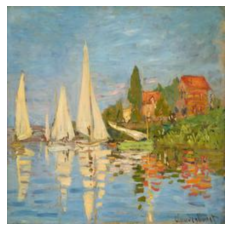

In [23]:
plt.imshow((training_data[0] * 127.5 + 127.5).astype('uint8'))
plt.axis('off')

In [24]:
BUFFER_SIZE = 60000
BATCH_SIZE = 100
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [25]:
def build_gen():
    model = Sequential()
    model.add(Dense(8 * 8 * 1024, use_bias=False, input_shape = (200,)))
    model.add(BatchNormalization())
    model.add(Reshape((8, 8, 1024)))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(3, (3, 3), strides = (2, 2), padding='same', use_bias=False))
    return model

In [26]:
gen = build_gen()

In [27]:
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             13107200  
_________________________________________________________________
batch_normalization_8 (Batch (None, 65536)             262144    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 8, 8, 512)         4718592   
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 512)        

In [28]:
def build_disc():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [29]:
disc = build_disc()

In [30]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4,0.5)

In [31]:
crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def gen_loss(fake_pred):
    return crossentropy(tf.ones_like(fake_pred), fake_pred)

In [33]:
def disc_loss(fake_pred, real_pred):
    real_loss = crossentropy(tf.ones_like(real_pred), real_pred)
    fake_loss = crossentropy(tf.zeros_like(fake_pred), fake_pred)
    total_loss = real_loss + fake_loss
    return total_loss

In [34]:
def train_step(images):
    noise = np.reshape(np.random.randn(100, 200).astype('float32'), (100, 200))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = gen(noise, training=True)
        fake_pred = disc(fake_images, training=True)
        generator_loss = gen_loss(fake_pred)
        real_pred = disc(images, training=True)
        discriminator_loss = disc_loss(fake_pred, real_pred)
    disc_gradients = disc_tape.gradient(discriminator_loss, disc.trainable_weights)
    gen_gradients = gen_tape.gradient(generator_loss, gen.trainable_weights)
    disc_optimizer.apply_gradients(zip(disc_gradients, disc.trainable_weights))
    gen_optimizer.apply_gradients(zip(gen_gradients, gen.trainable_weights))
    print('gen loss: ', np.mean(generator_loss))
    print('disc loss: ', np.mean(discriminator_loss))

In [35]:
# ! mkdir /kaggle/working/images
# ! mkdir /kaggle/working/outputs

In [39]:
def train(images, epochs):
    noise = np.random.randn(1, 200)
    for epoch in range(epochs):
        print('epoch: ', epoch)
        if epoch % 10 == 0:
            prediction = np.array(tf.reshape(np.array((gen(noise, training=False)) * 127.5 + 127.5).astype('uint8'), (1024, 1024, 3)))
            im = PIL.Image.fromarray(prediction)
            im.save("./outputs1/" + str(i) + ".jpg")
        for image in images:
            train_step(image)


In [42]:
train(train_dataset, 10000)


epoch:  0


In [ ]:
plt.imshow(np.array(tf.reshape(np.array((gen(np.random.randn(1, 200), training=False)) * 127.5 + 127.5).astype('uint8'), (1024, 1024, 3))))
plt.axis('off')

# # newimg = np.array(gen(np.random.randn(1, 100)) * 127.5 + 127.5).astype('uint8')[0]
# # newimg = np.array(cv2.resize(newimg, (64, 64)))
# # newimg = cv2.cvtColor(newimg, cv2.COLOR_RGB2BGR)
# # newimg = Image.fromarray(newimg)
# # newimg.save("/content/filename.png")
# # cv2.imwrite('/content/stuff.png', newimg)

In [ ]:
# for i in range(10):
#     print('epoch: ', i)
#     plt.imshow(np.array(tf.reshape(np.array((gen(np.random.randn(1, 200), training=False)) * 127.5 + 127.5).astype('uint8'), (256, 256, 3))))
#     plt.axis('off')
#     plt.savefig('/kaggle/working/images/' + str(i) + '.png')

In [ ]:
# gen.summary()

In [ ]:
# gen.save_weights('monetweights/genmonetweight10.h5f')

In [ ]:
# disc.save_weights('monetweights/discmonetweight10.h5f')

In [ ]:
# import PIL
# for i in range(7020):
#     if i % 100:
#         print(i)
#     prediction = np.array(tf.reshape(np.array((gen(np.random.randn(1, 200), training=False)) * 127.5 + 127.5).astype('uint8'), (256, 256, 3)))
#     im = PIL.Image.fromarray(prediction)
#     im.save("/kaggle/working/images/" + str(i) + ".jpg")

In [ ]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")
# # gen.save_weights('largergenweights3.h5f')
# # disc.save_weights('largerdisctweights3.h5f')